# Transfer Learning

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile

# Extract Zip
local_zip = '/content/drive/MyDrive/data/ImageCalssification.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [5]:
data_dir = "/content/ImageCalssification"

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=100,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3170 files belonging to 6 classes.
Using 2536 files for training.
Found 3170 files belonging to 6 classes.
Using 634 files for validation.


In [6]:
do_fine_tuning = True

In [7]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/50
79/79 [==============================] - 87s 883ms/step - loss: 1.0229 - accuracy: 0.7733 - val_loss: 1.4410 - val_accuracy: 0.6908
Epoch 2/50
79/79 [==============================] - 70s 886ms/step - loss: 0.7713 - accuracy: 0.8994 - val_loss: 0.8193 - val_accuracy: 0.8651
Epoch 3/50
79/79 [==============================] - 69s 873ms/step - loss: 0.7030 - accuracy: 0.9333 - val_loss: 0.6982 - val_accuracy: 0.9342
Epoch 4/50
79/79 [==============================] - 69s 867ms/step - loss: 0.6718 - accuracy: 0.9409 - val_loss: 0.6684 - val_accuracy: 0.9408
Epoch 5/50
79/79 [==============================] - 69s 873ms/step - loss: 0.6335 - accuracy: 0.9609 - val_loss: 0.6894 - val_accuracy: 0.9309
Epoch 6/50
79/79 [==============================] - 70s 880ms/step - loss: 0.6168 - accuracy: 0.9688 - val_loss: 0.6648 - val_accuracy: 0.9474
Epoch 7/50
79/79 [==============================] - 69s 870ms/step - loss: 0.6007 - accuracy: 0.9780 - val_loss: 0.6802 - val_accuracy: 0.9342

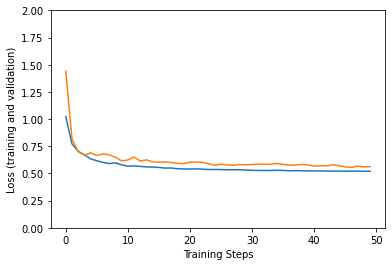

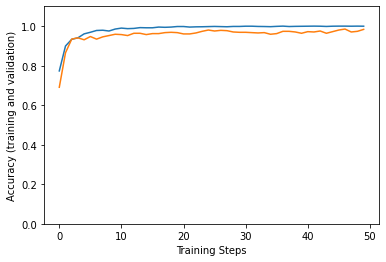

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

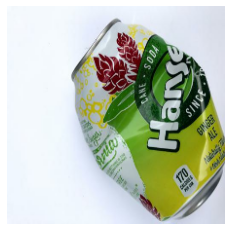

[[0.01934562 0.01706025 0.00832437 0.91675156 0.02131524 0.01720294]]
True label: Kaleng
Predicted label: Kaleng


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print(model.predict(np.expand_dims(image, axis=0)))
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [13]:
# Save Model
model.save("waste.h5")

# Convert to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('waste.tflite', 'wb') as f:
  f.write(tflite_model)

# Create Labels File
with open('labels.txt', 'w') as f:
    f.write('\n'.join('%s' % name for name in class_names))

INFO:tensorflow:Assets written to: /tmp/tmpr51vxal1/assets


INFO:tensorflow:Assets written to: /tmp/tmpr51vxal1/assets


In [14]:
# Download model and label
from google.colab import files
files.download('waste.h5')
files.download('waste.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=64)
  print(classes[0])
    
  for i in range(len(class_names)):
    if classes[0][i]>0.5:
      print("{} is {}".format(fn, class_names[i]))

Saving kaca.jpg to kaca.jpg
Saving plastik.jpg to plastik.jpg
[0.02968087 0.65541494 0.06233599 0.05697707 0.05270739 0.14288375]
kaca.jpg is Botol Kaca
[0.04586719 0.04982151 0.5673348  0.14090432 0.13981466 0.05625761]
plastik.jpg is Botol Plastik
